In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os

from matplotlib import pyplot as plt

In [0]:
# wget 명령어로 ngrok을 다운받은 후, unzip 명령어로 압축을 푼다
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-05-21 02:24:02--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.23.126.223, 52.22.127.224, 52.4.95.48, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.23.126.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2018-05-21 02:24:02 (41.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


# Get data

In [20]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':"1RKZB1T9Vr4LoEOQz4LP8Pq92rGDgrOUz"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv')  

#3. Read file as panda dataframe
data = pd.read_csv('data.csv') 
data.shape

(2293, 7)

In [21]:
data.head()

,Unnamed: 0,lineitem_id,data_at,ecpm_actual,impression_count,display_weight,revenue_actual
0,720,1502194,2017-12-01 00:00:00,1.03091,7385,-1.0,26.88
1,721,1502194,2017-12-02 00:00:00,0.71555,54305,-1.0,67.40
2,722,1502194,2017-12-03 00:00:00,0.56588,137353,-1.0,114.56
3,723,1502194,2017-12-04 00:00:00,0.49518,81242,-1.0,63.37
4,724,1502194,2017-12-05 00:00:00,0.79164,6690,17.0,21.06


# Process Data

In [0]:
def get_lineitems(threshold):
  temp = []
  for line_item in np.unique(data["lineitem_id"]):
    s = data[data["lineitem_id"] == line_item]["ecpm_actual"]
    if np.count_nonzero(s.values) > threshold:
      temp.append(line_item)
  return np.asarray(temp)

def sth_to_idx(arr):
  if type(arr) != "numpy.ndarray":
    arr = np.asarray(arr)
  to_idx, to_val = dict(), dict()
  i = 0
  for x in arr:
    to_val[i] = x
    to_idx[x] = i
    i += 1
  return to_idx, to_val

In [0]:
unique_items = np.unique(data["lineitem_id"])
unique_dates = np.unique(data["data_at"])

lineitem_to_idx, idx_to_lineitem = sth_to_idx(unique_items)
date_to_idx, idx_to_date = sth_to_idx(unique_dates)

In [24]:
lineitem_in_idx, date_in_idx = [], []

for i in range(len(data)):
  lineitem_in_idx.append(lineitem_to_idx[data["lineitem_id"].iloc[i]])
  date_in_idx.append(date_to_idx[data["data_at"].iloc[i]])
  
data["lineitem_in_idx"] = lineitem_in_idx
data["date_in_idx"] = date_in_idx

data.head()

,Unnamed: 0,lineitem_id,data_at,ecpm_actual,impression_count,display_weight,revenue_actual,lineitem_in_idx,date_in_idx
0,720,1502194,2017-12-01 00:00:00,1.03091,7385,-1.0,26.88,0,0
1,721,1502194,2017-12-02 00:00:00,0.71555,54305,-1.0,67.40,0,1
2,722,1502194,2017-12-03 00:00:00,0.56588,137353,-1.0,114.56,0,2
3,723,1502194,2017-12-04 00:00:00,0.49518,81242,-1.0,63.37,0,3
4,724,1502194,2017-12-05 00:00:00,0.79164,6690,17.0,21.06,0,4


In [25]:
data = data[["lineitem_in_idx", "date_in_idx", "ecpm_actual", "impression_count", "display_weight", "revenue_actual"]]
data = data.set_index("date_in_idx")
data.head()

,lineitem_in_idx,ecpm_actual,impression_count,display_weight,revenue_actual
date_in_idx,,,,,
0,0,1.03091,7385,-1.0,26.88
1,0,0.71555,54305,-1.0,67.40
2,0,0.56588,137353,-1.0,114.56
3,0,0.49518,81242,-1.0,63.37
4,0,0.79164,6690,17.0,21.06


In [206]:
data.describe()

,lineitem_in_idx,ecpm_actual,impression_count,display_weight,revenue_actual
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,7.729612,0.437544,11469.304405,137.742695,7.239445
std,5.206736,0.939286,23205.543140,307.522960,21.065585
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,3.000000,0.000000,0.000000,1.000000,-1.000000
50%,8.000000,0.192600,2150.000000,9.000000,0.438678
75%,12.000000,0.666250,12705.000000,35.000000,5.422778
max,17.000000,6.059610,163866.000000,1000.000000,361.301000


In [26]:
unique_items_idx = list(np.unique(data["lineitem_in_idx"]))
unique_date_idx = list(np.unique(data.index))

threshold = 100
for i in data["lineitem_in_idx"].value_counts().index:
  if data["lineitem_in_idx"].value_counts().loc[i] < threshold:
    unique_items_idx.remove(i)
    
print(unique_items_idx)
print(len(unique_items_idx))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16]
15


In [27]:
arr = np.full((len(unique_date_idx), len(unique_items_idx), 4), -1, dtype = np.float64)
print(arr.shape)

for i in range(len(unique_date_idx)):
  partial_df = data.loc[unique_date_idx[i]]
  if partial_df["display_weight"].sum() != 0:
    partial_df["display_weight_norm"] = partial_df["display_weight"] / partial_df["display_weight"].sum()

  for j in range(len(partial_df)):
    item_id = partial_df.iloc[j]["lineitem_in_idx"]
    if item_id in unique_items_idx:
    
      arr[i,unique_items_idx.index(item_id),0] = partial_df.iloc[j]["ecpm_actual"]
      arr[i,unique_items_idx.index(item_id),1] = partial_df.iloc[j]["impression_count"]
      arr[i,unique_items_idx.index(item_id),2] = partial_df.iloc[j]["display_weight_norm"]    
      arr[i,unique_items_idx.index(item_id),3] = partial_df.iloc[j]["revenue_actual"]

(167, 15, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### Note
- ```x_data```: ecpm & impression during the past n days
- ```y_data```: display weight for current day (i.e., policy in RL context)
- ```z_data```: ecpm & impression for current day
- ```r_data```: actual revenuve for current day

In [0]:
def create_dataset(arr, look_back):
  x_dataset, y_dataset, z_dataset, r_dataset = [], [], [], []

  for i in range(look_back, arr.shape[0]):
    x_dataset.append(arr[i - look_back: i, :, :2].flatten())       # past ecpm/impression
    y_dataset.append(arr[i, :, 2])                                 # display weights
    z_dataset.append(arr[i, :, :2].flatten())                      # current ecpm/impression
    r_dataset.append(arr[i, :, 3])                                 # revenue
  return np.asarray(x_dataset), np.asarray(y_dataset), np.asarray(z_dataset), np.asarray(r_dataset)

In [0]:
TEST_SIZE = .1
LOOK_BACK = 3

In [29]:
x_train, y_train, z_train, r_train = create_dataset(arr, LOOK_BACK)

print(x_train.shape, y_train.shape, z_train.shape, r_train.shape)

(164, 90) (164, 15) (164, 30) (164, 15)


In [0]:
def train_test_split(x_data, y_data, z_data, r_data, test_size):
  idx = np.random.choice(len(x_data), len(x_data))
  where = int(len(idx) * (1-test_size))
  train_idx, test_idx = idx[:where], idx[where:]
  x_train, y_train, z_train, r_train = x_data[train_idx], y_data[train_idx], z_data[train_idx], r_data[train_idx]
  x_test, y_test, z_test, r_test = x_data[test_idx], y_data[test_idx], z_data[test_idx], r_data[test_idx]
  return x_train, y_train, z_train, r_train, x_test, y_test, z_test, r_test

In [35]:
x_train, y_train, z_train, r_train, x_test, y_test, z_test, r_test = train_test_split(x_train, y_train, z_train, r_train, test_size = TEST_SIZE)

print(x_train.shape, y_train.shape, z_train.shape, r_train.shape, x_test.shape, y_test.shape, z_test.shape, r_test.shape)

(147, 90) (147, 15) (147, 30) (147, 15) (17, 90) (17, 15) (17, 30) (17, 15)


In [36]:
center = int(z_test.shape[1]/2)
print(center)

15


# Create model

In [0]:
class prototype_model:

  def __init__(self, train_data, test_data, skip_step, batch_size, learning_rate, shuffle_buffer, alpha, beta, gamma):
    tf.reset_default_graph()
    self.train_data = train_data
    self.test_data = test_data
    self.skip_step = skip_step
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.shuffle_buffer = shuffle_buffer
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    self.global_step = tf.get_variable('global_step', initializer=tf.constant(0), trainable=False)
    
  def _generate_dataset(self):
    train_dataset = tf.data.Dataset.from_tensor_slices(self.train_data)
    train_dataset = train_dataset.shuffle(self.shuffle_buffer)
    train_dataset = train_dataset.batch(self.batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices(self.test_data)
    test_dataset = test_dataset.batch(self.batch_size)
    
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes) 
    self.X, self.Y, self.Z, self.R = iterator.get_next()
    self.train_init = iterator.make_initializer(train_dataset)
    self.test_init = iterator.make_initializer(test_dataset)
  
  def _create_model(self):
    with tf.name_scope("weights"):
      self.w1 = tf.get_variable(name = "weight_x_to_y", shape = (self.train_data[0].shape[1], self.train_data[1].shape[1]), initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)
      self.w2 = tf.get_variable(name = "weight_x_to_z", shape = (self.train_data[0].shape[1], self.train_data[2].shape[1]), initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)
      self.w3 = tf.get_variable(name = "weight_y_to_z", shape = (self.train_data[1].shape[1], self.train_data[2].shape[1]), initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)
      self.w4 = tf.get_variable(name = "weight_z_to_r", shape = (self.train_data[2].shape[1], self.train_data[3].shape[1]), initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)
      
    with tf.name_scope("matrix_multiplication"):
      self.y = tf.matmul(self.X, self.w1)
      self.z = tf.matmul(self.X, self.w2) + tf.matmul(self.y, self.w3)
      self.r = tf.matmul(self.z, self.w4)
    
  def _create_cost_function(self):
    with tf.name_scope("losses"):
      self.ecpm_loss = tf.reduce_mean(tf.square(self.Z[:, center:] - self.z[:, center:]), name = "ecpm_loss")
      self.impression_loss = tf.reduce_mean(tf.square(self.Z[:, :center] - self.z[:, :center]), name = "impression_loss")
      self.revenue = - tf.reduce_mean(self.r, name = "revenue")
      
      self.cost = tf.constant(self.alpha, dtype = tf.float64) * self.ecpm_loss + \
                  tf.constant(self.beta, dtype = tf.float64) * self.impression_loss + \
                  tf.constant(self.gamma, dtype = tf.float64) * self.revenue
      
  def _create_optimizer(self):
    with tf.name_scope("optimizer"):
      self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.cost, global_step = self.global_step)
      
  def build_graph(self):
    self._generate_dataset()
    self._create_model()
    self._create_cost_function()
    self._create_optimizer()
  

  def train(self, num_epochs):
    saver = tf.train.Saver()
    with tf.Session() as sess:
      
      sess.run(tf.global_variables_initializer())
      ckpt = tf.train.get_checkpoint_state(os.getcwd())
      cost_trace, loss1_trace, loss2_trace, revenue_trace = [], [], [], []
      
      
      for i in range(num_epochs):
        sess.run(self.train_init)
        total_cost, total_loss1, total_loss2, total_revenue = 0, 0, 0, 0
        try:
          while True:
            _, c, l_a, l_b, l_c = sess.run([self.optimizer, self.cost, self.ecpm_loss, self.impression_loss, self.revenue])
            total_cost += c
            total_loss1 += l_a
            total_loss2 += l_b
            total_revenue += l_c
      
        except tf.errors.OutOfRangeError:
          pass
        
        if (i +1) % self.skip_step == 0:
          print("AVG COST @ {}: ".format(i+1), total_cost/self.skip_step, total_loss1/self.skip_step, total_loss2/self.skip_step, total_revenue/self.skip_step)
          saver.save(sess, os.getcwd() + "/model", global_step = self.global_step)
          
        cost_trace.append(total_cost / len(self.train_data[0]))
        loss1_trace.append(total_loss1 / len(self.train_data[0]))
        loss2_trace.append(total_loss2 / len(self.train_data[0]))
        revenue_trace.append(total_revenue / len(self.train_data[0]))
    return cost_trace, loss1_trace, loss2_trace, revenue_trace

  
  def evaluate(self, ckpt_name):
    saver = tf.train.Saver()
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      saver.restore(sess, os.path.join(os.getcwd(), ckpt_name))
        
      sess.run(self.test_init)
      total_cost, total_loss1, total_loss2, total_revenue = 0, 0, 0, 0
      try:
        while True:
          c, l_a, l_b, l_c = sess.run([self.cost, self.ecpm_loss, self.impression_loss, self.revenue])
          total_cost += c
          total_loss1 += l_a
          total_loss2 += l_b
          total_revenue += l_c      

      except tf.errors.OutOfRangeError:
        pass
      
      return total_cost / len(self.test_data[0]), total_loss1 / len(self.test_data[0]), total_loss2/ len(self.test_data[0]), total_revenue / len(self.test_data[0])
  
  def get_weights(self, ckpt_name):
    saver = tf.train.Saver()
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      saver.restore(sess, os.path.join(os.getcwd(), ckpt_name))
      w1_out, w2_out, w3_out, w4_out  = sess.run([self.w1, self.w2, self.w3, self.w4])
      return w1_out, w2_out, w3_out,w4_out 

In [0]:
TRAIN_DATA = (x_train, y_train, z_train, r_train)
TEST_DATA = (x_test, y_test, z_test, r_test)
SKIP_STEP = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.001
SHUFFLE_BUFFER = 10
ALPHA = 0.0               # ecpm
BETA = 0.0                # impression
GAMMA = 1.0               # revenue
NUM_EP0CHS = 100000

In [0]:
model = prototype_model(TRAIN_DATA, TEST_DATA, SKIP_STEP, BATCH_SIZE, LEARNING_RATE, SHUFFLE_BUFFER, ALPHA, BETA, GAMMA)
model.build_graph()

In [190]:
cost_trace, loss1_trace, loss2_trace, revenue_trace = model.train(NUM_EP0CHS)

AVG COST @ 1000:  -1582733.791747064 756062519247.2695 754802161153.8663 -1582733.791747064
AVG COST @ 2000:  -10716788.781381378 9560294999045.326 9541707251704.152 -10716788.781381378
AVG COST @ 3000:  -30688388.714284424 38678366100152.32 38612913745828.11 -30688388.714284424
AVG COST @ 4000:  -63141884.159444414 100930507319737.45 100781496933881.75 -63141884.159444414
AVG COST @ 5000:  -109396340.3347595 209632935669094.47 209358517341300.6 -109396340.3347595
AVG COST @ 6000:  -170768937.4745989 379099284395155.75 378652886700274.06 -170768937.4745989
AVG COST @ 7000:  -248623521.64799032 624915717725260.1 624246075902121.2 -248623521.64799032
AVG COST @ 8000:  -344357064.3990873 964034864084216.1 963085987576973.0 -344357064.3990873
AVG COST @ 9000:  -459381203.1212416 1414788370704827.0 1413499528238253.8 -459381203.1212416
AVG COST @ 10000:  -595110081.108578 1996873083557947.8 1995178810593040.2 -595110081.108578
AVG COST @ 11000:  -752954038.386949 2731332935562221.0 27291630

KeyboardInterrupt: ignored

In [169]:
# finding checkpoints..
!dir

checkpoint			  model-99700.data-00000-of-00001
data_2.csv			  model-99700.index
data.csv			  model-99700.meta
datalab				  model-99800.data-00000-of-00001
DE_Slidejoy.csv			  model-99800.index
IN_Slidejoy.csv			  model-99800.meta
model-100000.data-00000-of-00001  model-99900.data-00000-of-00001
model-100000.index		  model-99900.index
model-100000.meta		  model-99900.meta
model-99600.data-00000-of-00001   ngrok
model-99600.index		  ngrok-stable-linux-amd64.zip
model-99600.meta


In [205]:
test_cost, test_loss1, test_loss2, test_revenue = [], [], [], []

for i in range(0, 10000, 100):
  model = prototype_model(TRAIN_DATA, TEST_DATA, SKIP_STEP, BATCH_SIZE, LEARNING_RATE, SHUFFLE_BUFFER, ALPHA, BETA, GAMMA)
  model.build_graph()
  cost_trace, loss1_trace, loss2_trace, revenue_trace = model.train(i+1)
  try:
    c, l1, l2, r = model.evaluate("model-" + str(i))
    test_cost.append(c)
    test_loss1.append(l1)
    test_loss2.append(l2)
    test_revenue.append(r)
  except:
    pass

INFO:tensorflow:Restoring parameters from /content/model-0
AVG COST @ 100:  -11365.339055437904 579445536.4049444 612569918.7808089 -11365.339055437904
INFO:tensorflow:Restoring parameters from /content/model-100
AVG COST @ 100:  -8034.907842240414 340074771.1403044 464005915.1606665 -8034.907842240414
AVG COST @ 200:  -92146.3639288813 8502577422.206452 9844738586.080965 -92146.3639288813
INFO:tensorflow:Restoring parameters from /content/model-200
AVG COST @ 100:  -10454.133835854245 487632771.74676216 516136837.2106384 -10454.133835854245
AVG COST @ 200:  -102885.30298126185 9423361629.178709 10189805911.820358 -102885.30298126185
AVG COST @ 300:  -394413.021723626 55464546170.264465 58863996755.67816 -394413.021723626
INFO:tensorflow:Restoring parameters from /content/model-300
AVG COST @ 100:  -9885.52712550436 496185048.26710975 586175258.9887854 -9885.52712550436
AVG COST @ 200:  -100318.76969587282 9863558968.171598 10110671701.13166 -100318.76969587282
AVG COST @ 300:  -389483

AVG COST @ 900:  -11687943.550569672 5120579747223.409 5067615801695.369 -11687943.550569672
AVG COST @ 1000:  -15834889.553586375 7649142466801.733 7573624633270.128 -15834889.553586375
AVG COST @ 1100:  -20779496.252575867 10956706999105.94 10853264841979.793 -20779496.252575867
AVG COST @ 1200:  -26565392.768804383 15164227464132.037 15027047403912.213 -26565392.768804383
AVG COST @ 1300:  -33231939.35989119 20394899282152.637 20217759580664.703 -33231939.35989119
INFO:tensorflow:Restoring parameters from /content/model-1300
AVG COST @ 100:  -11245.37994813748 402785167.4028531 601907332.5295941 -11245.37994813748
AVG COST @ 200:  -105199.23303368111 8652075870.679358 10507254313.206593 -105199.23303368111
AVG COST @ 300:  -399033.3783522129 52491698150.12083 59376053240.38386 -399033.3783522129
AVG COST @ 400:  -1001818.7527583251 180967881079.5924 198169563622.45 -1001818.7527583251
AVG COST @ 500:  -2010163.0129004836 460459370679.6726 495038220669.6861 -2010163.0129004836
AVG CO

AVG COST @ 400:  -1000510.8716296448 199445058455.36383 196653248210.00848 -1000510.8716296448
AVG COST @ 500:  -2009322.7064666043 498951590951.79156 492323117867.10455 -2009322.7064666043
AVG COST @ 600:  -3509327.402356025 1040314430835.7102 1027327724439.7482 -3509327.402356025
AVG COST @ 700:  -5576447.886510228 1916721969368.4832 1894246477238.4062 -5576447.886510228
AVG COST @ 800:  -8278315.446456857 3229945647762.149 3194278873923.912 -8278315.446456857
AVG COST @ 900:  -11675316.391559532 5088493175277.771 5035400171939.878 -11675316.391559532
AVG COST @ 1000:  -15821493.330560414 7606106772422.893 7530859558495.736 -15821493.330560414
AVG COST @ 1100:  -20765330.87448378 10900546724921.422 10797962252390.521 -20765330.87448378
AVG COST @ 1200:  -26550443.672403183 15092610955810.895 14957086889108.91 -26550443.672403183
AVG COST @ 1300:  -33216182.160271667 20305351423155.363 20130899361384.94 -33216182.160271667
AVG COST @ 1400:  -40798165.40285324 26663452917829.44 2644372

AVG COST @ 1200:  -26557285.198867664 15027467171569.69 14897948187864.068 -26557285.198867664
AVG COST @ 1300:  -33222846.712310813 20218628066035.453 20058642611283.336 -33222846.712310813
AVG COST @ 1400:  -40804648.63753512 26551250465200.594 26357023566213.645 -40804648.63753512
AVG COST @ 1500:  -49335052.14637147 34150940890977.85 33918601793765.094 -49335052.14637147
AVG COST @ 1600:  -58843569.90402563 43144094397864.7 42869685216818.52 -58843569.90402563
AVG COST @ 1700:  -69357232.1903973 53657610546947.09 53337093588669.79 -69357232.1903973
AVG COST @ 1800:  -80900910.4204922 65818685736497.87 65447949698296.99 -80900910.4204922
AVG COST @ 1900:  -93497601.67331319 79754666727883.8 79329531941051.73 -93497601.67331319
AVG COST @ 2000:  -107168679.91138892 95592955017482.31 95109177871578.36 -107168679.91138892
AVG COST @ 2100:  -121934117.29973665 113460951965629.16 112914228630034.31 -121934117.29973665
AVG COST @ 2200:  -137812678.56070876 133486035959954.9 13287200550307

AVG COST @ 400:  -999520.2449254238 203730894521.40802 199374707231.7609 -999520.2449254238
AVG COST @ 500:  -2007799.4451447544 507614128289.5988 498133452758.3323 -2007799.4451447544
AVG COST @ 600:  -3507223.114776415 1055440168630.6943 1038133756695.0358 -3507223.114776415
AVG COST @ 700:  -5573732.36380792 1940692992836.3518 1912430586352.07 -5573732.36380792
AVG COST @ 800:  -8274968.499015327 3265404024571.4 3222673378421.3086 -8274968.499015327
AVG COST @ 900:  -11671323.382609129 5138311094658.841 5077258069977.685 -11671323.382609129
AVG COST @ 1000:  -15816842.657104818 7673361194946.628 7589824406082.558 -15816842.657104818
AVG COST @ 1100:  -20760012.521260556 10988497695177.762 10878038673467.35 -20760012.521260556
AVG COST @ 1200:  -26544448.37738228 15204682950891.676 15062612518548.027 -26544448.37738228
AVG COST @ 1300:  -33209500.937021915 20445117260757.508 20266518638207.93 -33209500.937021915
AVG COST @ 1400:  -40790789.27452668 26834619840494.71 26614368915075.11

AVG COST @ 900:  -11656403.085968655 5049335096859.216 4925935425722.818 -11656403.085968655
AVG COST @ 1000:  -15799335.939362776 7549354911774.35 7385034491278.776 -15799335.939362776
AVG COST @ 1100:  -20739830.729465786 10821849185153.984 10609368817229.174 -20739830.729465786
AVG COST @ 1200:  -26521503.235816985 14987235727395.71 14719019095837.918 -26521503.235816985
AVG COST @ 1300:  -33183704.135568213 20168214339303.086 19836380383438.504 -33183704.135568213
AVG COST @ 1400:  -40762052.38242745 26489143818052.406 26085534823598.24 -40762052.38242745
AVG COST @ 1500:  -49288904.54047858 34075553074807.516 33591759077810.453 -49288904.54047858
AVG COST @ 1600:  -58793770.317811824 43053765243187.42 42481145217582.1 -58793770.317811824
AVG COST @ 1700:  -69303678.28043918 53550613197745.5 52880313445944.64 -69303678.28043918
AVG COST @ 1800:  -80843499.05932629 65693231417331.05 64916201508212.46 -80843499.05932629
AVG COST @ 1900:  -93436229.63912271 79608909053067.06 787159156

AVG COST @ 600:  -3499094.272096119 1013731798047.1776 1009685672489.7294 -3499094.272096119
AVG COST @ 700:  -5562371.185718373 1873028038855.3345 1866770438951.0437 -5562371.185718373
AVG COST @ 800:  -8260188.266935543 3163360405001.175 3154319943018.509 -8260188.266935543
AVG COST @ 900:  -11652968.376725841 4992562106198.244 4980143011148.024 -11652968.376725841
AVG COST @ 1000:  -15794775.210720437 7473752818753.08 7457339834556.365 -15794775.210720437
AVG COST @ 1100:  -20734105.533474002 10724118872547.1 10703080881929.197 -20734105.533474002
AVG COST @ 1200:  -26514580.936645117 14863929305097.54 14837622051225.785 -26514580.936645117
AVG COST @ 1300:  -33175555.759699866 20015748671280.336 19983516821667.49 -33175555.759699866
AVG COST @ 1400:  -40752651.22080655 26303812290188.57 26264991011787.79 -40752651.22080655
AVG COST @ 1500:  -49278225.239306524 33853535864396.324 33807452029352.37 -49278225.239306524
AVG COST @ 1600:  -58781788.28985299 42791138284403.66 42737111391

AVG COST @ 2900:  -281319234.0121625 340162114690596.44 343089396875361.56 -281319234.0121625
AVG COST @ 3000:  -306671596.71757954 381617519855472.0 384813970028489.8 -306671596.71757954
AVG COST @ 3100:  -333273799.3227742 426359689173432.75 429839030225283.06 -333273799.3227742
AVG COST @ 3200:  -361139181.2045448 474517794563170.2 478293913204300.06 -361139181.2045448
AVG COST @ 3300:  -390280926.9936419 526221574318894.5 530308518589765.8 -390280926.9936419
AVG COST @ 3400:  -420712102.7014835 581601396994088.6 586013374224110.9 -420712102.7014835
AVG COST @ 3500:  -452445688.4941984 640788326309025.2 645539701485010.8 -452445688.4941984
INFO:tensorflow:Restoring parameters from /content/model-3500
AVG COST @ 100:  -10705.4948970967 699538471.062288 454355393.570533 -10705.4948970967
AVG COST @ 200:  -100850.82477615922 11318895123.807983 8677121612.901928 -100850.82477615922
AVG COST @ 300:  -388938.71690023504 62259325145.894196 53061270782.29744 -388938.71690023504
AVG COST @ 4

AVG COST @ 1100:  -20770033.444520995 10817725285641.26 10754617313613.201 -20770033.444520995
AVG COST @ 1200:  -26555561.467221305 14985031291962.732 14901323168979.875 -26555561.467221305
AVG COST @ 1300:  -33221742.932405535 20168869886886.637 20060784039116.625 -33221742.932405535
AVG COST @ 1400:  -40804196.82832923 26493711815378.5 26357246463760.055 -40804196.82832923
AVG COST @ 1500:  -49335279.45110707 34085190784653.395 33916137471584.79 -49335279.45110707
AVG COST @ 1600:  -58844499.94807268 43069727834626.17 42863687272406.875 -58844499.94807268
AVG COST @ 1700:  -69358886.06776406 53574247218995.81 53326643556338.94 -69358886.06776406
AVG COST @ 1800:  -80903307.41276154 65725968688841.83 65432062299517.52 -80903307.41276154
AVG COST @ 1900:  -93500759.77444234 79652261007579.61 79307159916187.69 -93500759.77444234
AVG COST @ 2000:  -107172616.21093282 95480546337637.08 95079216393185.66 -107172616.21093282
AVG COST @ 2100:  -121938848.26234747 113338245403344.7 112875519

AVG COST @ 2400:  -172862790.358696 180840384415169.7 181536596413516.16 -172862790.358696
AVG COST @ 2500:  -192177349.11485112 208148386735269.88 208923222083824.4 -192177349.11485112
AVG COST @ 2600:  -212671020.16786054 238126882555986.2 238985245725843.6 -212671020.16786054
AVG COST @ 2700:  -234358716.63551104 270903596435430.56 271850460258447.75 -234358716.63551104
AVG COST @ 2800:  -257254902.15252063 306606465710206.06 307646869233565.25 -257254902.15252063
AVG COST @ 2900:  -281373667.71099 345363709018920.06 346502755690360.44 -281373667.71099
AVG COST @ 3000:  -306728798.0217832 387303895929583.94 388546752070921.5 -306728798.0217832
AVG COST @ 3100:  -333333829.56363016 432556017872002.6 433907911407029.5 -333333829.56363016
AVG COST @ 3200:  -361202100.47578776 481249557906317.2 482715777309508.0 -361202100.47578776
AVG COST @ 3300:  -390346794.2435521 533514560234869.75 535100453675104.0 -390346794.2435521
AVG COST @ 3400:  -420780975.81895137 589481694975007.0 59119266

AVG COST @ 3300:  -390690780.3119746 534385143079931.06 534570245906795.75 -390690780.3119746
AVG COST @ 3400:  -421139428.1372498 590411702219895.8 590613456672222.4 -421139428.1372498
AVG COST @ 3500:  -452890760.3762368 650273946970394.8 650493212494796.5 -452890760.3762368
AVG COST @ 3600:  -485957694.1198252 714104008197905.5 714341655966020.1 -485957694.1198252
AVG COST @ 3700:  -520353110.56862533 782034826792555.0 782291739486958.9 -520353110.56862533
AVG COST @ 3800:  -556089874.0413849 854200207592654.4 854477279223139.5 -556089874.0413849
AVG COST @ 3900:  -593180847.756501 930734869698239.0 931033005444766.9 -593180847.756501
AVG COST @ 4000:  -631638907.5955112 1011774494862580.4 1012094610942082.2 -631638907.5955112
AVG COST @ 4100:  -671476952.3760574 1097455770252697.9 1097798793806186.1 -671476952.3760574
AVG COST @ 4200:  -712707913.6515913 1187916431307504.8 1188283300305823.0 -712707913.6515913
INFO:tensorflow:Restoring parameters from /content/model-4200
AVG COST @

AVG COST @ 3800:  -555694797.7104359 852301439714896.8 846572066216334.8 -555694797.7104359
AVG COST @ 3900:  -592771252.0649799 928706130015593.2 922595848586343.2 -592771252.0649799
AVG COST @ 4000:  -631214596.7756473 1009610715932199.2 1003105452003651.9 -631214596.7756473
AVG COST @ 4100:  -671037732.3419621 1095151829867979.5 1088237371324512.4 -671037732.3419621
AVG COST @ 4200:  -712253591.8986123 1185467152703955.5 1178129149683209.0 -712253591.8986123
AVG COST @ 4300:  -754875147.3856099 1280695449523078.0 1272919414148191.2 -754875147.3856099
AVG COST @ 4400:  -798915415.4628665 1380976605037549.8 1372747911083663.0 -798915415.4628665
INFO:tensorflow:Restoring parameters from /content/model-4400
AVG COST @ 100:  -10999.970371353425 611580186.1224515 626868412.5735106 -10999.970371353425
AVG COST @ 200:  -105934.28644227033 10823823278.162315 10759957192.77448 -105934.28644227033
AVG COST @ 300:  -400778.0191113695 60584876376.69121 60496557480.67191 -400778.0191113695
AVG CO

AVG COST @ 3900:  -592626175.3732818 921920456674223.9 927305414830910.9 -592626175.3732818
AVG COST @ 4000:  -631064139.8913325 1002388983855222.8 1008117920778293.8 -631064139.8913325
AVG COST @ 4100:  -670881822.8347229 1087478452317596.0 1093563535021420.4 -670881822.8347229
AVG COST @ 4200:  -712092157.8889035 1177326393037711.2 1183779903239100.5 -712092157.8889035
AVG COST @ 4300:  -754708117.511742 1272071420860155.2 1278905755353651.2 -754708117.511742
AVG COST @ 4400:  -798742718.8498704 1371853269856654.8 1379080940932356.2 -798742718.8498704
AVG COST @ 4500:  -844209027.8203393 1476812824732262.8 1484446460621408.2 -844209027.8203393
AVG COST @ 4600:  -891120162.1282773 1587092149650375.0 1595144494990594.0 -891120162.1282773
INFO:tensorflow:Restoring parameters from /content/model-4600
AVG COST @ 100:  -11361.780287883426 520297238.19493216 618645783.2619126 -11361.780287883426
AVG COST @ 200:  -106085.09825343842 9801235123.66628 10813155418.811136 -106085.09825343842
AVG

AVG COST @ 3600:  -485918541.2075612 712319486215837.5 714417042218145.6 -485918541.2075612
AVG COST @ 3700:  -520312372.98047906 780119697038211.2 782372057332867.2 -520312372.98047906
AVG COST @ 3800:  -556047531.3718969 852149129549063.9 854562684088944.1 -556047531.3718969
AVG COST @ 3900:  -593136879.6672755 928542445450713.1 931123652982366.9 -593136879.6672755
AVG COST @ 4000:  -631593293.8159058 1009435269281999.4 1012190657089334.4 -631593293.8159058
AVG COST @ 4100:  -671429672.7033453 1094964231121444.0 1097900394843942.9 -671429672.7033453
AVG COST @ 4200:  -712658947.950622 1185267009391136.2 1188390612912060.2 -712658947.950622
AVG COST @ 4300:  -755294090.0787758 1280482366593397.2 1283800141979277.8 -755294090.0787758
AVG COST @ 4400:  -799348114.4182365 1380750184749054.5 1384268932237243.8 -799348114.4182365
AVG COST @ 4500:  -844834085.1833658 1486211496861958.5 1489938084886035.8 -844834085.1833658
AVG COST @ 4600:  -891765118.4832182 1597008515789811.8 160094988103

AVG COST @ 2900:  -281527472.00685287 346408612998452.7 344297793119719.9 -281527472.00685287
AVG COST @ 3000:  -306889812.6887396 388441540533278.0 386131200401411.7 -306889812.6887396
AVG COST @ 3100:  -333502171.39064974 433790977664729.75 431270610255318.6 -333502171.39064974
AVG COST @ 3200:  -361377885.12267417 482586460785151.5 479845426677115.6 -361377885.12267417
AVG COST @ 3300:  -390530136.26544243 534958086627464.06 531985616341634.2 -390530136.26544243
AVG COST @ 3400:  -420971988.697348 591036577182758.5 587821773135564.5 -420971988.697348
AVG COST @ 3500:  -452716420.5679562 650953345550851.9 647485183657289.6 -452716420.5679562
AVG COST @ 3600:  -485776350.13330317 714840554738170.8 711107885726394.6 -485776350.13330317
AVG COST @ 3700:  -520164659.69290125 782831177390104.6 778822727849486.1 -520164659.69290125
AVG COST @ 3800:  -555894214.6003842 855059049780768.0 850763422988942.2 -555894214.6003842
AVG COST @ 3900:  -592977879.0475959 931658922183097.5 9270645987436

AVG COST @ 1800:  -80836804.16849656 65183793614963.76 65689297052505.74 -80836804.16849656
AVG COST @ 1900:  -93429462.19924642 79020162866455.66 79614132589882.06 -93429462.19924642
AVG COST @ 2000:  -107096401.32593304 94750063116810.92 95441211282764.92 -107096401.32593304
AVG COST @ 2100:  -121857594.25898865 112500701903756.27 113297969557115.45 -121857594.25898865
AVG COST @ 2200:  -137731806.67846015 132399275220653.55 133311818510001.92 -137731806.67846015
AVG COST @ 2300:  -154736768.2557926 154572969326182.03 155610147347027.3 -154736768.2557926
AVG COST @ 2400:  -172889323.32168758 179148983451812.4 180320347558306.47 -172889323.32168758
AVG COST @ 2500:  -192205561.8347838 206254566419674.12 207569850845375.8 -192205561.8347838
AVG COST @ 2600:  -212700935.1344117 236017066364501.62 237486180022446.56 -212700935.1344117
AVG COST @ 2700:  -234390356.58447284 268563988059676.0 270197007391194.38 -234390356.58447284
AVG COST @ 2800:  -257288290.02859738 304023056986505.6 3058

AVG COST @ 300:  -376224.5087008282 56021723883.07803 51366322474.64753 -376224.5087008282
AVG COST @ 400:  -970105.2831602852 192719328494.49387 181164067872.67075 -970105.2831602852
AVG COST @ 500:  -1970380.0550080433 487859229878.5619 464905142460.56647 -1970380.0550080433
AVG COST @ 600:  -3462355.448660348 1023665935394.2993 983892185256.8511 -3462355.448660348
AVG COST @ 700:  -5521786.081359277 1893159561093.963 1830314292554.686 -5521786.081359277
AVG COST @ 800:  -8216158.208985892 3197912652230.3506 3104992898454.9487 -8216158.208985892
AVG COST @ 900:  -11605743.705590945 5046221350796.013 4915544135615.084 -11605743.705590945
AVG COST @ 1000:  -15744498.009143 7551614656522.919 7374880469096.83 -15744498.009143
AVG COST @ 1100:  -20680840.52895619 10831644560967.111 10599994015530.422 -20680840.52895619
AVG COST @ 1200:  -26458337.763613842 15006909385676.88 14710973741259.902 -26458337.763613842
AVG COST @ 1300:  -33116305.023259066 20200272154508.777 19830218273355.82 -3

AVG COST @ 3900:  -593001134.0947542 925463894318633.5 932023897206921.5 -593001134.0947542
AVG COST @ 4000:  -631452411.7164385 1006155707406528.6 1013153926591928.5 -631452411.7164385
AVG COST @ 4100:  -671283583.1090759 1091476314103744.5 1098929163966588.6 -671283583.1090759
AVG COST @ 4200:  -712507580.4356067 1181563320232714.8 1189487382781739.0 -712507580.4356067
AVG COST @ 4300:  -755137374.7258372 1276555415652637.2 1284967440455876.2 -755137374.7258372
AVG COST @ 4400:  -799185981.7877659 1376592409653720.0 1385509313881680.8 -799185981.7877659
AVG COST @ 4500:  -844666466.2840686 1481815262388280.8 1491254130944623.8 -844666466.2840686
AVG COST @ 4600:  -891591944.7447177 1592366113714701.8 1602344199438705.0 -891591944.7447177
AVG COST @ 4700:  -939975587.257932 1708388308601470.0 1718923032523857.2 -939975587.257932
AVG COST @ 4800:  -989830618.851613 1830026421273783.2 1841135372919391.0 -989830618.851613
AVG COST @ 4900:  -1041170319.9359573 1957426276513202.5 196912721

AVG COST @ 1800:  -80881586.50484405 65938097970609.46 64939971514892.79 -80881586.50484405
AVG COST @ 1900:  -93477875.94238406 79895749019859.27 78738535355076.98 -93477875.94238406
AVG COST @ 2000:  -107148538.48262678 95757849053531.77 94427413547676.55 -107148538.48262678
AVG COST @ 2100:  -121913545.79373205 113651853806572.0 112133752922643.98 -121913545.79373205
AVG COST @ 2200:  -137791662.4850543 133705193070432.66 131984692207543.73 -137791662.4850543
AVG COST @ 2300:  -154800617.14424714 156045274280116.88 154107363349115.25 -154800617.14424714
AVG COST @ 2400:  -172957253.01811257 180799506819199.28 178628913792138.22 -172957253.01811257
AVG COST @ 2500:  -192277658.99167714 208095340053920.0 205676542725865.84 -192277658.99167714
AVG COST @ 2600:  -212777285.34952378 238060314328059.28 235377550478097.2 -212777285.34952378
AVG COST @ 2700:  -234471044.42624995 270822119415463.44 267859395556572.38 -234471044.42624995
AVG COST @ 2800:  -257373399.06674927 306508659594860.4

AVG COST @ 5100:  -1147825169.379388 2224751698953358.8 2222802676531066.0 -1147825169.379388
AVG COST @ 5200:  -1203683859.9476757 2370059321172940.0 2368019216490410.0 -1203683859.9476757
AVG COST @ 5300:  -1261080719.5864103 2521717294313339.0 2519583709338517.0 -1261080719.5864103
AVG COST @ 5400:  -1320029294.7516394 2679877872644438.5 2677648388886470.0 -1320029294.7516394
AVG COST @ 5500:  -1380543180.363616 2844694647657905.5 2842366826078988.0 -1380543180.363616
AVG COST @ 5600:  -1442636017.7326758 3016322556959494.0 3013893937891552.0 -1442636017.7326758
AVG COST @ 5700:  -1506321492.4676983 3194917892200094.5 3192385995266094.5 -1506321492.4676983
AVG COST @ 5800:  -1571613332.2532763 3380638305752166.0 3378000629792133.0 -1571613332.2532763
INFO:tensorflow:Restoring parameters from /content/model-5800
AVG COST @ 100:  -6945.940759283328 251115966.5997731 368200807.42818475 -6945.940759283328
AVG COST @ 200:  -89606.47005457543 7551877620.618963 8814243981.655693 -89606.470

AVG COST @ 2400:  -172945665.76493776 179580592098394.3 177973027457205.47 -172945665.76493776
AVG COST @ 2500:  -192264770.26983747 206735063786253.53 204945359094390.47 -192264770.26983747
AVG COST @ 2600:  -212763068.6395942 236549562937514.0 234566303944369.56 -212763068.6395942
AVG COST @ 2700:  -234455473.1594768 269151641124414.38 266963251827451.12 -234455473.1594768
AVG COST @ 2800:  -257356446.61290255 304669068981722.25 302263816709225.2 -257356446.61290255
AVG COST @ 2900:  -281480079.1361906 343229903872603.4 340595903593942.6 -281480079.1361906
AVG COST @ 3000:  -306840154.59087163 384962558760548.8 382087776722063.06 -306840154.59087163
AVG COST @ 3100:  -333450208.6211918 429995872470373.8 426868129235483.5 -333450208.6211918
AVG COST @ 3200:  -361323578.5529774 478459178867543.44 475066151839014.75 -361323578.5529774
AVG COST @ 3300:  -390473447.0837643 530482375846170.3 526811601330491.44 -390473447.0837643
AVG COST @ 3400:  -420912878.40647817 586195989653959.9 58223

AVG COST @ 5400:  -1319969318.2088504 2692789080219009.5 2689634314812281.0 -1319969318.2088504
AVG COST @ 5500:  -1380481918.7515664 2858219284114364.0 2854917083917367.5 -1380481918.7515664
AVG COST @ 5600:  -1442573461.3785162 3030477354005406.0 3027023769824720.0 -1442573461.3785162
AVG COST @ 5700:  -1506257631.7849352 3209719734651052.0 3206110781766347.0 -1506257631.7849352
AVG COST @ 5800:  -1571548157.7346268 3396104231811702.5 3392335889897699.0 -1571548157.7346268
AVG COST @ 5900:  -1638458806.710179 3589790017667472.5 3585858230719789.0 -1638458806.710179
AVG COST @ 6000:  -1707003383.7199264 3790937635824196.5 3786838312088846.0 -1707003383.7199264
AVG COST @ 6100:  -1777195728.958068 3999709005071206.5 3995438016978260.0 -1777195728.958068
INFO:tensorflow:Restoring parameters from /content/model-6100
AVG COST @ 100:  -10063.162866260644 456053370.8888882 419455437.3249628 -10063.162866260644
AVG COST @ 200:  -98383.41148768127 9182006132.843655 8068351704.001407 -98383.41

AVG COST @ 2100:  -121949868.57997487 113168600471920.56 113459423981048.36 -121949868.57997487
AVG COST @ 2200:  -137828936.80767274 133154313301609.06 133489791706169.19 -137828936.80767274
AVG COST @ 2300:  -154838867.7513991 155421597962760.7 155805599690467.03 -154838867.7513991
AVG COST @ 2400:  -172996504.3982936 180097773004884.12 180534255297242.1 -172996504.3982936
AVG COST @ 2500:  -192317935.13535923 207310200846711.56 207803205227602.47 -192317935.13535923
AVG COST @ 2600:  -212818609.5889611 237186338251877.2 237739986537777.16 -212818609.5889611
AVG COST @ 2700:  -234513439.33355615 269853794323623.75 270472285118748.62 -234513439.33355615
AVG COST @ 2800:  -257416886.39525092 305440395171589.75 306128000799266.0 -257416886.39525092
AVG COST @ 2900:  -281543040.13037646 344074251866296.2 344835315689572.06 -281543040.13037646
AVG COST @ 3000:  -306905683.6155377 385883829565274.25 386722763653214.8 -306905683.6155377
AVG COST @ 3100:  -333518351.7182416 430998018000002.9

AVG COST @ 4800:  -989810146.1802833 1842553055573025.2 1826756048420689.0 -989810146.1802833
AVG COST @ 4900:  -1041149338.4026865 1970611307835228.2 1953990177071430.8 -1041149338.4026865
AVG COST @ 5000:  -1093986531.1898713 2104598007458192.8 2087128427416699.5 -1093986531.1898713
AVG COST @ 5100:  -1148335114.579783 2244661717389011.0 2226319138495839.8 -1148335114.579783
AVG COST @ 5200:  -1204208532.0058877 2390952302708955.0 2371711950789180.0 -1204208532.0058877
AVG COST @ 5300:  -1261620278.9277334 2543620944135537.0 2523457819731485.0 -1261620278.9277334
AVG COST @ 5400:  -1320583901.16023 2702820149828908.0 2681709027535286.5 -1320583901.16023
AVG COST @ 5500:  -1381112993.0190935 2868703765789399.0 2846619193608951.0 -1381112993.0190935
AVG COST @ 5600:  -1443221195.2441735 3041426984731460.0 3018343283455330.5 -1443221195.2441735
AVG COST @ 5700:  -1506922192.9055488 3221146353994484.5 3197037616608176.5 -1506922192.9055488
AVG COST @ 5800:  -1572229713.1784735 3408019782

AVG COST @ 900:  -11663666.821312683 5051843139450.249 4988105285653.028 -11663666.821312683
AVG COST @ 1000:  -15808326.351119857 7555594504151.61 7467055438193.299 -15808326.351119857
AVG COST @ 1100:  -20750631.00445517 10833222549531.33 10714469067516.836 -20750631.00445517
AVG COST @ 1200:  -26534189.90497919 15005309219953.96 14850530764446.875 -26534189.90497919
AVG COST @ 1300:  -33198349.011850987 20194707075703.004 19997728003122.99 -33198349.011850987
AVG COST @ 1400:  -40778723.8495033 26525916838294.875 26280225804868.28 -40778723.8495033
AVG COST @ 1500:  -49307668.41986681 34124599164633.246 33823375729664.746 -49307668.41986681
AVG COST @ 1600:  -58814690.45894129 43117199475919.35 42753338055600.87 -58814690.45894129
AVG COST @ 1700:  -69326816.9661375 53630664218405.57 53196795567152.56 -69326816.9661375
AVG COST @ 1800:  -80868917.28759329 65792233466099.22 65280743864934.46 -80868917.28759329
AVG COST @ 1900:  -93463987.3212152 79729294705527.4 79132343048916.73 -93

AVG COST @ 3300:  -390619779.10574913 532757778121393.7 535321943932641.8 -390619779.10574913
AVG COST @ 3400:  -421065012.2090122 588659694598907.1 591422668174548.4 -421065012.2090122
AVG COST @ 3500:  -452812876.3113564 648392063759395.1 651362332369364.8 -452812876.3113564
AVG COST @ 3600:  -485876288.85311943 712086964090504.1 715273101553391.4 -485876288.85311943
AVG COST @ 3700:  -520268131.36759436 779877284183255.5 783287950601379.6 -520268131.36759436
AVG COST @ 3800:  -556001268.4903098 851896776594097.6 855540718207478.1 -556001268.4903098
AVG COST @ 3900:  -593088563.7413365 928280108106805.9 932166157246264.6 -593088563.7413365
AVG COST @ 4000:  -631542893.2894505 1009162908078616.1 1013299983205903.5 -631542893.2894505
AVG COST @ 4100:  -671377156.2258384 1094681811167873.0 1099078916980929.5 -671377156.2258384
AVG COST @ 4200:  -712604284.3643601 1184974500159796.5 1189640727760790.5 -712604284.3643601
AVG COST @ 4300:  -755237248.407139 1280179741723458.5 1285124268826

AVG COST @ 5600:  -1442976536.795042 3018916557122587.5 3022714458597458.5 -1442976536.795042
AVG COST @ 5700:  -1506671113.0638556 3197621223510637.0 3201602055359890.5 -1506671113.0638556
AVG COST @ 5800:  -1571972147.2601752 3383453592435353.5 3387622456854413.0 -1571972147.2601752
AVG COST @ 5900:  -1638893406.5181763 3576572704005872.5 3580934751454742.5 -1638893406.5181763
AVG COST @ 6000:  -1707448695.5178514 3777138969568140.0 3781699398809335.0 -1707448695.5178514
AVG COST @ 6100:  -1777651854.1436245 3985314175472182.5 3990078233608228.0 -1777651854.1436245
AVG COST @ 6200:  -1849516755.2122047 4201261486232442.0 4206234468742532.0 -1849516755.2122047
AVG COST @ 6300:  -1923057302.1774938 4425145446842380.0 4430332697617514.0 -1923057302.1774938
AVG COST @ 6400:  -1998287426.950068 4657131984686047.0 4662538896062490.0 -1998287426.950068
AVG COST @ 6500:  -2075221087.8313856 4897388411099100.0 4903020423889983.0 -2075221087.8313856
AVG COST @ 6600:  -2153872267.3741417 514608

AVG COST @ 900:  -11667519.014807658 4938520007889.05 4864369530275.204 -11667519.014807658
AVG COST @ 1000:  -15812729.908111451 7398260175344.418 7298814478969.045 -15812729.908111451
AVG COST @ 1100:  -20755599.009212956 10622281783879.518 10492938125561.201 -20755599.009212956
AVG COST @ 1200:  -26539735.29521681 14730463555184.69 14566394967755.99 -26539735.29521681


KeyboardInterrupt: ignored

In [203]:
!dir

checkpoint			  model-16000.index
data_2.csv			  model-16000.meta
data.csv			  model-200.data-00000-of-00001
datalab				  model-200.index
DE_Slidejoy.csv			  model-200.meta
IN_Slidejoy.csv			  model-300.data-00000-of-00001
model-100000.data-00000-of-00001  model-300.index
model-100000.index		  model-300.meta
model-100000.meta		  model-400.data-00000-of-00001
model-100.data-00000-of-00001	  model-400.index
model-100.index			  model-400.meta
model-100.meta			  model-99600.data-00000-of-00001
model-12000.data-00000-of-00001   model-99600.index
model-12000.index		  model-99600.meta
model-12000.meta		  model-99700.data-00000-of-00001
model-13000.data-00000-of-00001   model-99700.index
model-13000.index		  model-99700.meta
model-13000.meta		  model-99800.data-00000-of-00001
model-14000.data-00000-of-00001   model-99800.index
model-14000.index		  model-99800.meta
model-14000.meta		  model-99900.data-00000-of-00001
model-15000.data-00000-of-00001   model-99900.index
model-15000.index		  model-9

# Model Evaluation

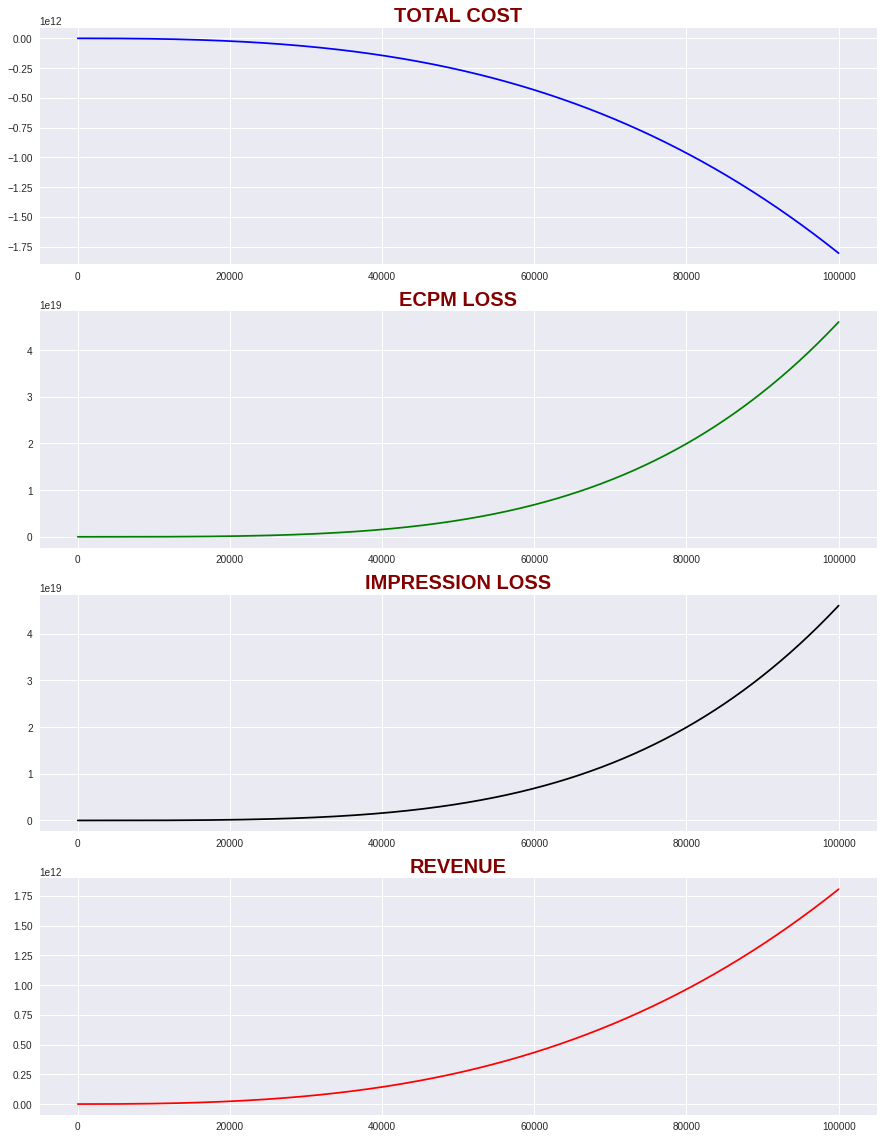

In [184]:
# training loss (over 100,000 epochs)
fig, axes = plt.subplots(4, 1, figsize = (15, 20))
axes[0].plot(np.arange(len(cost_trace)), cost_trace, label = "total_cost", color = "b")
axes[0].set_title("TOTAL COST", size = 20, fontweight = "bold", color = "#840000")
axes[1].plot(np.arange(len(loss1_trace)), loss1_trace, label = "ecpm_loss", color = "g")
axes[1].set_title("ECPM LOSS", size = 20, fontweight = "bold", color = "#840000")
axes[2].plot(np.arange(len(loss2_trace)), loss2_trace, label = "impression_loss", color = "k")
axes[2].set_title("IMPRESSION LOSS", size = 20, fontweight = "bold", color = "#840000")
axes[3].plot(np.arange(len(revenue_trace)), - np.asarray(revenue_trace), label = "revenue", color = "r")
axes[3].set_title("REVENUE", size = 20, fontweight = "bold", color = "#840000")
plt.show()

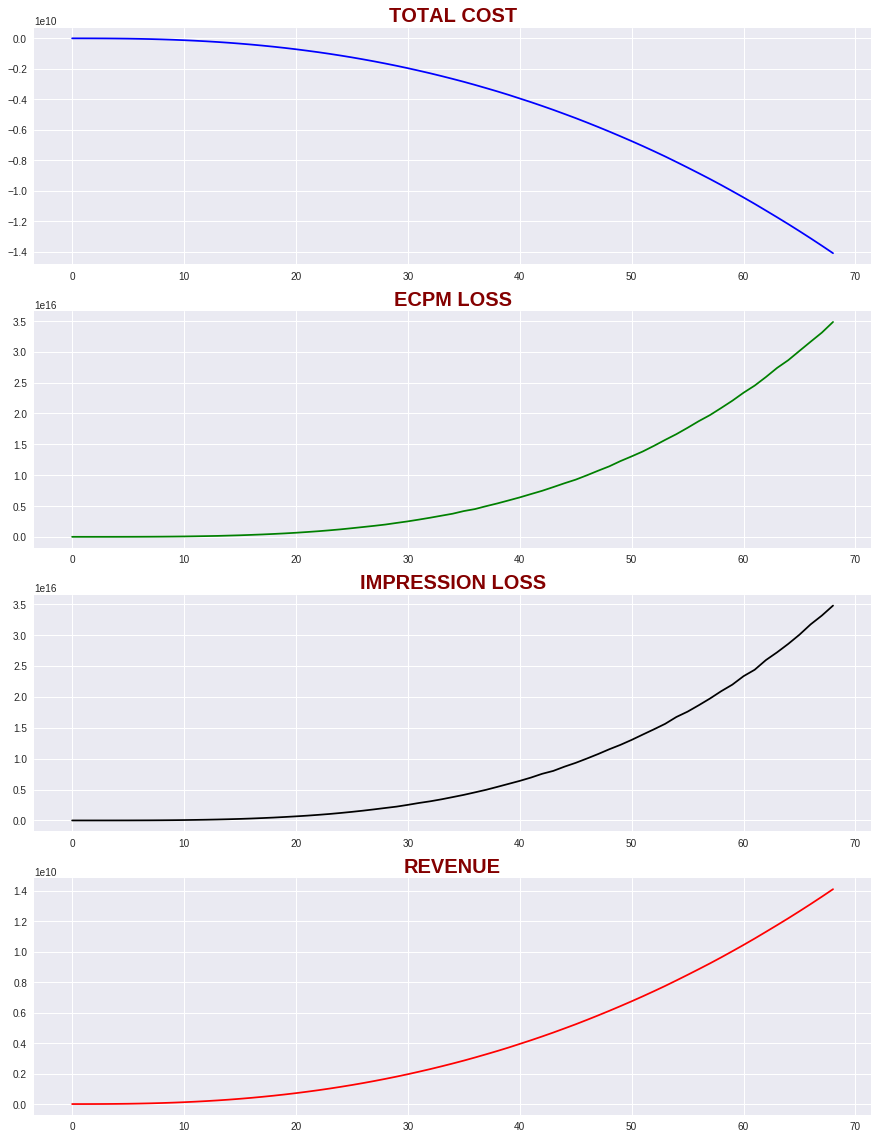

In [208]:
# test loss
fig, axes = plt.subplots(4, 1, figsize = (15, 20))
axes[0].plot(np.arange(len(test_cost)), test_cost, label = "total_cost", color = "b")
axes[0].set_title("TOTAL COST", size = 20, fontweight = "bold", color = "#840000")
axes[1].plot(np.arange(len(test_loss1)), test_loss1, label = "ecpm_loss", color = "g")
axes[1].set_title("ECPM LOSS", size = 20, fontweight = "bold", color = "#840000")
axes[2].plot(np.arange(len(test_loss2)), test_loss2, label = "impression_loss", color = "k")
axes[2].set_title("IMPRESSION LOSS", size = 20, fontweight = "bold", color = "#840000")
axes[3].plot(np.arange(len(test_revenue)), - np.asarray(test_revenue), label = "revenue", color = "r")
axes[3].set_title("REVENUE", size = 20, fontweight = "bold", color = "#840000")
plt.show()

# Model visualization using TensorBoard

In [0]:
# 이벤트 파일을 저장하기 위한 디렉토리를 설정
log_dir = "/tmp/log"

In [212]:
model.train(1)

([-11.97103138656643],
 [4946314.244129821],
 [12916935.11179862],
 [-11.97103138656643])

In [0]:
# FileWriter를 통해 default graph를 지정한 디렉토리에 저장
writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

In [214]:
# 생성되는 url을 클릭하면 텐서보드가 실행된다
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(log_dir))
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://0315ffc4.ngrok.io


# Weight out

In [230]:
model = prototype_model(TRAIN_DATA, TEST_DATA, SKIP_STEP, BATCH_SIZE, LEARNING_RATE, SHUFFLE_BUFFER, ALPHA, BETA, GAMMA)
model.build_graph()
cost_trace, loss1_trace, loss2_trace, revenue_trace = model.train(50000)
w1_out, _, _, _ = model.get_weights("model-50000")

INFO:tensorflow:Restoring parameters from /content/model-50000


In [231]:
w1_reshaped = w1_out.reshape(LOOK_BACK, len(unique_items_idx), 2, -1)
print(w1_reshaped.shape)

w_d_1 = w1_reshaped[0, :]
w_d_2 = w1_reshaped[1, :]
w_d_3 = w1_reshaped[2, :]

w_d_1_ecpm = w_d_1[:, 0, :]
w_d_1_impr = w_d_1[:, 1, :]
w_d_2_ecpm = w_d_2[:, 0, :]
w_d_2_impr = w_d_2[:, 1, :]
w_d_3_ecpm = w_d_3[:, 0, :]
w_d_3_impr = w_d_3[:, 1, :]

(3, 15, 2, 15)


In [220]:
for idx in unique_items_idx:
  print(idx, ": ", idx_to_lineitem[idx])

0 :  1502194
1 :  1502195
2 :  1502196
3 :  1517681
4 :  1551830
5 :  1551854
6 :  1551919
7 :  1551943
8 :  1556534
9 :  1564540
11 :  1569123
12 :  1573255
13 :  1573614
15 :  1578852
16 :  1605216


In [0]:
from google.colab import files
np.savetxt("out.csv", w_d_3_impr, delimiter = ",")
files.download("out.csv")